In [1]:
"""
Imports necessary for this notebook
"""
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import shdom



In [2]:
def calccenterofmass(droplets):
    lwc = droplets.lwc.data
    mx = np.sum(np.sum(lwc,2),1)
    my = np.sum(np.sum(lwc,2),0)
    mz = np.sum(np.sum(lwc,0),0)
    com_x = sum(mx * droplets.grid.x)/sum(mx)
    com_y = sum(my * droplets.grid.y)/sum(my)
    com_z = sum(mz * droplets.grid.z)/sum(mz)
    return com_x, com_y, com_z

def projection_split(projections, n_parts):
    avg = len(projections.projection_list) / float(n_parts)
    out = []
    last = 0.0

    while last < len(projections.projection_list):
        out.append(shdom.MultiViewProjection(projections.projection_list[int(last):int(last + avg)]))
        last += avg

    return out

In [3]:
"""
Set settings
"""
#355, 380, 445, 470, 555, 660, 865, 935
N_angle_steps = 8
N_cameras = 9
wavelengths = [0.660]
vel_cloud = np.array([0.0,0.0,0.0]) # m/s
# A fly over from West to East (positive y-axis direction)
# camera_zenith_list = [70.5, 60, 45.6, 26.1, 0, 26.1, 45.6, 60, 70.5]
# camera_azimuth_list = [-90, -90, -90, -90, 0, 90, 90, 90, 90]
# camera_zenith_list = [70.5,  45.6, 26.1, 26.1, 45.6,  70.5]
# camera_azimuth_list = [-90, -90, -90, 90, 90,  90]
num_of_viewed_medium = 1
projection_type = 'perspective'
# projection_type = 'pushbroom'
# projection_type = 'orthographic'

# input_cloud = 'rico52x57x26'
# input_cloud = 'rico32x37x26'
input_cloud = 'WIZ'
input_cloud = 'voxel'

if len(wavelengths) > 1:
    type = 'polychromatic'
else:
    type = 'monochromatic'




# sun
sun_azimuth=65
sun_zenith=165

# solver
iter = 100

In [4]:
# Mie scattering for water droplets
mie_table_paths = [
    '../../mie_tables/polydisperse/Water_{}nm.scat'.format(shdom.int_round(wavelength)) 
    for wavelength in wavelengths
]

solar_spectrum = shdom.SolarSpectrum('../../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths)
solar_fluxes = solar_fluxes / max(solar_fluxes)

In [5]:
# Load a Microphysical scatterer
droplets = shdom.MicrophysicalScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    camera_height = 3 #km
    droplets.load_from_csv('../../synthetic_cloud_fields/jpl_les/{}.txt'.format(input_cloud), veff=0.1)
elif input_cloud == 'voxel':
    camera_height = 20
    data_dir = '../../synthetic_cloud_fields/WIZ_Clouds/BOMEX2'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    volumes_paths = [volumes_paths[i] for i in range(100,100+4*num_of_viewed_medium,4)]
    droplets.load_from_csv(volumes_paths[0])
    grid = shdom.Grid(x=droplets.grid.x[357:400],y=droplets.grid.y[340:370],z=np.linspace(0,1.5,45))

else:
    camera_height = 20 #km
    assert np.any(vel_cloud==np.array([0.0,0.0,0.0]))
    data_dir = '../../synthetic_cloud_fields/WIZ_Clouds/BOMEX2'
    format_ = '*.txt'# load 
    volumes_paths = sorted(glob.glob(data_dir + '/'+format_))
    volumes_paths = [volumes_paths[i] for i in range(100,100+4*num_of_viewed_medium,4)]
    droplets.load_from_csv(volumes_paths[0])
    grid = shdom.Grid(x=droplets.grid.x[357:400],y=droplets.grid.y[340:370],z=np.linspace(0,1.5,45))


In [6]:
droplets.resample(grid)
com_x, com_y, com_z = calccenterofmass(droplets=droplets)
com = np.array([com_x, com_y, com_z])

In [7]:
df = pd.read_csv('../../ancillary_data/AFGL_summer_mid_lat.txt', comment='#', sep=' ')
temperatures = df['Temperature(k)'].to_numpy(dtype=np.float32)
altitudes = df['Altitude(km)'].to_numpy(dtype=np.float32)
temperature_profile = shdom.GridData(shdom.Grid(z=altitudes), temperatures)
air_grid = shdom.Grid(z=np.linspace(0, 20, 20))


In [8]:
air = shdom.MultispectralScatterer()
mie_list = []
for wavelength, table_path in zip(wavelengths, mie_table_paths):  
        # Molecular Rayleigh scattering
        rayleigh = shdom.Rayleigh(wavelength)
        rayleigh.set_profile(temperature_profile.resample(air_grid))
        air.add_scatterer(rayleigh.get_scatterer())
        mie = shdom.MiePolydisperse()
        mie.read_table(table_path)
        mie_list.append(mie)
        
temporary_scatterer_list = []
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    for mie in mie_list:  
        droplets.add_mie(mie)
else:
    time_list = [0]
    for volumes_path in volumes_paths:
        droplets = shdom.MicrophysicalScatterer()
        droplets.load_from_csv(volumes_path)
        for mie in mie_list:  
            droplets.add_mie(mie)
        droplets.resample(grid)
        for data in [droplets.lwc.data, droplets.reff.data, droplets.veff.data]:
            data[0,:,:] = 0
            data[:,0,:] = 0
            data[:,:,0] = 0
            data[-1,:,:] = 0
            data[:,-1,:] = 0
            data[:,:,-1] = 0
        if input_cloud == 'voxel':
            data = droplets.lwc.data
            data[:,:,:] = 0
            data[20:22,15:17,20:21] = 0.3
            data = droplets.reff.data
            data[:,:,:] = 0
            data[20:22,15:17,20:21] = 10
            data = droplets.veff.data
            data[:,:,:] = 0
            data[20:22,15:17,20:21] = 0.1
            
            
            
        
        temporary_scatterer_list.append(shdom.TemporaryScatterer(droplets,0)) 
time_list = np.mean(np.split(np.array(time_list),num_of_viewed_medium),1)

Reading mie table from file: ../../mie_tables/polydisperse/Water_660nm.scat
Minimum medium effective radius [0.11] is smaller than the pre-computed table minimum radius [1.00]. Recompute Mie table with smaller minimum radius. Setting exceptioned values to pre-computed minimal value
Minimum medium effective variance [0.00] is smaller than the pre-computed table minimum variance [0.02]. Recompute Mie table with smaller minimum variance. Setting exceptioned values to pre-computed minimal value


In [9]:
# c = np.sum(a>0)
# b = np.sum(a,2)
# plt.imshow(b)
# print(a[a>0].min())
# plt.colorbar()

In [10]:
dynamic_scatterer = shdom.DynamicScatterer()
if input_cloud == 'rico52x57x26' or input_cloud == 'rico32x37x26':
    dynamic_scatterer.generate_dynamic_scatterer(scatterer=droplets, time_list=time_list, scatterer_velocity_list=vel_cloud)
else:
    dynamic_scatterer.add_temporary_scatterer(temporary_scatterer_list)

dynamic_medium = shdom.DynamicMedium(dynamic_scatterer,air=air)

In [11]:
scene_params_list = []
numerical_params_list =[]
for wavelength, solar_flux in zip(wavelengths, solar_fluxes):
    scene_params = shdom.SceneParameters(
        wavelength=wavelength,
        source=shdom.SolarSource(azimuth=sun_azimuth, zenith=sun_zenith, flux=solar_flux),
    )
    scene_params_list.append(scene_params)
    numerical_params = shdom.NumericalParameters(num_mu_bins=8,num_phi_bins=16)
    numerical_params_list.append(numerical_params)

In [12]:
dynamic_solver = shdom.DynamicRteSolver(scene_params=[scene_params_list],numerical_params=[numerical_params_list])
dynamic_solver.set_dynamic_medium(dynamic_medium)
dynamic_solver.solve(maxiter=iter,verbose=True)

In [13]:

for i in range(0,1):
    projections = shdom.MultiViewProjection()

    angle_span = 16*(i+1)*0+2
    # y_max = np.tan(np.deg2rad(angle_span/2))*camera_height
    # y_min = -y_max
    ang = np.linspace(-angle_span/2,angle_span ,N_cameras)
    y = camera_height * np.cos(np.deg2rad(ang))
    z = camera_height * np.abs(np.sin(np.deg2rad(ang)))
    # L = np.linspace(y_min,y_max ,N_cameras)
    for j in range(N_cameras):
        if projection_type == 'pushbroom':
            projection = (
        
                    shdom.PushBroomProjection(fov=3, nx=200, ny=200, x=com_x, 
                                              y=com_y+y[j]
                    ,z=z[j],bounding_box=droplets.bounding_box)
                )  
            projection.look_at_transform(point=com, up=[0.0, 0.0, 1.0])
            projections.add_projection(projection)
        if projection_type == 'perspective':
             projection = (
                    shdom.PerspectiveProjection(fov=.5, 
                    nx=100, ny=100, x=com_x, y=com_y+y[j],
                    z=z[j])
                )  
             projection.look_at_transform(point=com, up=[0.0, 0.0, 1.0])
             projections.add_projection(projection)
    dynamic_projection = shdom.DynamicProjection(projection_split(projections, num_of_viewed_medium))
    dynamic_camera = shdom.DynamicCamera(shdom.RadianceSensor(), dynamic_projection)
    images = dynamic_camera.render(dynamic_solver,n_jobs=40)
    measurements = shdom.DynamicMeasurements(camera=dynamic_camera, images=images, wavelength=wavelengths,time_list=time_list)
    output_dir = 'experiments/{}_wl_img_{}_projection_{}_span_{}_/dynamic_medium_{}'.format(input_cloud, N_cameras,
                                                                                   projection_type,angle_span,type)
    shdom.save_dynamic_forward_model(output_dir, dynamic_medium, dynamic_solver, measurements)
    print(i)

0


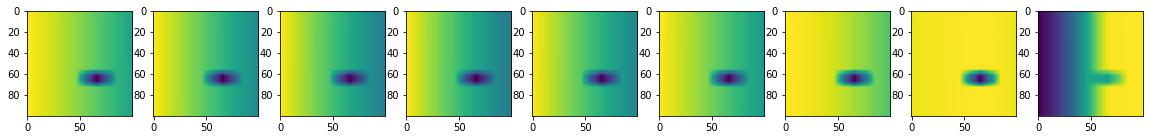

In [14]:
%matplotlib inline
f, axarr = plt.subplots(1, len(images), figsize=(20, 20))
if isinstance(axarr,plt.Axes):
    axarr = [axarr]
for ax, image in zip(axarr, images):
    if len(image.shape)>2 and image.shape[2]==2:
        image = np.concatenate((np.reshape(image[:,:,0],(image.shape[0],image.shape[1],1)),image),2)
    elif len(image.shape)>2 and image.shape[2]>3:
        image = image[:,:,0:2]
    ax.imshow(image/image.max())


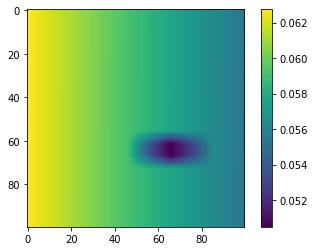

In [15]:
plt.imshow(images[3])
plt.colorbar()
